### Import libraries and data

In [1]:
import numpy as np
import sklearn.datasets, sklearn.decomposition
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import pandas as pd
import scipy
import scipy.io as sio
import torch
from torch import nn, optim
from torch.utils import data
from pyriemann.utils.mean import mean_covariance
import torch.nn.functional as F
import sklearn.datasets
import sklearn.decomposition
file = loadmat('../data/static_FHA_FCs_5periods.mat')
FHA_FCs = file['sFC_5periods']
FHA_FCs.shape

(62, 286, 286, 5)

### Define CNN Architecture

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(12)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(10800, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (3, 3)))
        x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)), (3, 3)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Define functions

In [25]:
def get_data(index):
    '''
    Gets subset of FCs based on index of 4th dimension (period)
    These are 0: Rest1; 1: Rest2; 2: Task; 3: Rest3; 4: Rest4
    '''
    file = loadmat('../data/static_FHA_FCs_5periods.mat')
    all_FC = file['sFC_5periods']
    nSubj = all_FC.shape[0]
    all_FC = all_FC[:,:,:,index]
    if isinstance(index, list):
        all_FC = all_FC.reshape(-1, all_FC.shape[1], all_FC.shape[2])
    print(all_FC.shape)
    return all_FC, nSubj

def build_model(lr):
    '''
    Given layer sizes and learning rate, builds model.
    Can change NN architecture here directly in nn.Sequential
    '''
    model = Net()
    if use_cuda:
        model = model.cuda()
    loss_fn = nn.BCELoss()
    opt = optim.SGD(model.parameters(), lr=lr)
    history = {}
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []
    return model, loss_fn, opt, history

def q1invm(q1, eig_thresh=0):
    U, S, V = scipy.linalg.svd(q1)
    s = np.diag(S)
    s[s < eig_thresh] = eig_thresh
    S = np.diag(s ** (-1 / 2))
    Q1_inv_sqrt = U * S * np.transpose(V)
    Q1_inv_sqrt = (Q1_inv_sqrt + np.transpose(Q1_inv_sqrt)) / 2
    return Q1_inv_sqrt


def qlog(q):
    U, S, V = scipy.linalg.svd(q)
    s = np.diag(S)
    S = np.diag(np.log(s))
    Q = U * S * np.transpose(V)
    return Q

def tangential(all_FC, ref):
    # Regularization for riemann
    if ref == 'none':
        return all_FC
    if ref in ['riemann', 'kullback_sym', 'logeuclid']:
        print("Adding regularization!")
        eye_mat = np.eye(all_FC.shape[1])
        scaling_mat = np.repeat(eye_mat[None, ...], all_FC.shape[0], axis=0)
        all_FC += scaling_mat
    Cg = mean_covariance(all_FC, metric=ref)
    Q1_inv_sqrt = q1invm(Cg)
    Q = Q1_inv_sqrt @ all_FC @ Q1_inv_sqrt
    tangent_FC = np.array([qlog(a) for a in Q])
    return tangent_FC

def prepare_data(all_FC, pos_indices, nSubj):
    '''
    Prepares labels and train, val and test data from raw data
    '''
    labels = np.zeros((nSubj), dtype=int)
    labels[pos_indices-1] = 1 # positive family history = 1
    labels = np.tile(labels, int(all_FC.shape[0]/nSubj))
    labels = torch.tensor(labels)
    indices = np.random.permutation(all_FC.shape[0])
    # Take subsets of data for training, validation, test
    train_val_idx = indices[:int(0.8 * all_FC.shape[0])]
    # Val, train, test indices
    val_idx = train_val_idx[int(0.8 * train_val_idx.shape[0]):]
    train_idx = train_val_idx[:int(0.8 * train_val_idx.shape[0])]
    test_idx = indices[int(0.8 * all_FC.shape[0]):]
    # Normalize based on mean and std of training data
    train_mean = np.mean(all_FC[train_idx])
    train_std = np.std(all_FC[train_idx])
    train_data = torch.FloatTensor(
        (all_FC[train_idx] - train_mean) / train_std)
    val_data = torch.FloatTensor(
        (all_FC[val_idx] - train_mean) / train_std)
    test_data = torch.FloatTensor(
        (all_FC[test_idx] - train_mean) / train_std)

    train_data = train_data.view(
        train_data.shape[0], -1, train_data.shape[1], train_data.shape[2])
    val_data = val_data.view(
        val_data.shape[0], -1, val_data.shape[1], val_data.shape[2])
    test_data = test_data.view(
        test_data.shape[0], -1, test_data.shape[1], test_data.shape[2])

    train_dataset = data.TensorDataset(
        train_data, labels[train_idx])  # create your datset
    val_dataset = data.TensorDataset(
        val_data, labels[val_idx])  # create your datset
    test_dataset = data.TensorDataset(
        test_data, labels[test_idx])  # create your datset

    train_loader = data.DataLoader(
        train_dataset, batch_size=10)  # create your dataloader
    val_loader = data.DataLoader(
        val_dataset, batch_size=10)  # create your dataloader
    test_loader = data.DataLoader(
        test_dataset, batch_size=10)  # create your dataloader
    return train_loader, val_loader, test_loader


def train_model(model, opt, loss_fn, train_loader, val_loader,
                max_epochs, n_epochs_stop, history):
    '''
    Trains model with specified parameters and returns trained model
    '''
    early_stop = False
    min_val_loss = np.Inf
    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss = 0.0
        num_train_correct = 0
        num_train_examples = 0
        for local_batch, local_labels in train_loader:
            # Transfer to GPU
            if use_cuda:
                local_batch, local_labels = local_batch.to(
                    device), local_labels.to(device)

            opt.zero_grad()
            output = model(local_batch)
            local_labels = local_labels.float()
            loss = loss_fn(output, local_labels)
            loss.backward()
            opt.step()

            train_loss += loss.data.item() * local_batch.size(0)
            num_train_correct += (torch.max(output, 1)
                                  [1] == local_labels).sum().item()
            num_train_examples += local_batch.shape[0]

            train_acc = num_train_correct / num_train_examples
            train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        num_val_correct = 0
        num_val_examples = 0
        with torch.set_grad_enabled(False):
            for local_batch, local_labels in val_loader:
                # Transfer to GPU
                if use_cuda:
                    local_batch, local_labels = local_batch.to(
                        device), local_labels.to(device)
                local_labels = local_labels.float()
                output = model(local_batch)
                loss = loss_fn(output, local_labels)

                val_loss += loss.data.item() * local_batch.size(0)
                num_val_correct += (torch.max(output, 1)
                                    [1] == local_labels).sum().item()
                num_val_examples += local_batch.shape[0]

            val_acc = num_val_correct / num_val_examples
            val_loss = val_loss / len(val_loader.dataset)

            if val_loss < min_val_loss:
                epochs_no_improve = 0
                min_val_loss = val_loss
            else:
                epochs_no_improve += 1
        # Check early stopping condition
            if epochs_no_improve == n_epochs_stop:
                early_stop = print('Early stopping!')
                break
        if epoch % 1 == 0:
            print(f'Epoch {epoch + 1} / {max_epochs},'
                  f'train loss: {train_loss: 5.4f},'
                  f'train acc: {train_acc: 5.3f}, val loss: {val_loss: 5.3f},'
                  f'val acc: {val_acc: 5.3f}')

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if early_stop:
            print("Stopped")
            break
    return model, history

def test_model(model, test_loader):
    '''
    After trained model is returned, this function tests the accuracy
    on novel data. Returns test accuracy of a model.
    '''
    model.eval()
    num_correct = 0
    num_examples = 0
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in test_loader:
            # Transfer to GPU
            if use_cuda:
                local_batch, local_labels = local_batch.to(
                    device), local_labels.to(device)
            output = model(local_batch)
            num_correct += (torch.max(output, 1)
                            [1] == local_labels).sum().item()
            num_examples += local_batch.shape[0]

        test_acc = num_correct / num_examples
    return test_acc

### Negative and positive family history of alcohol

In [26]:
alcohol_indices = loadmat('../data/alcohol.mat')
neg_indices = alcohol_indices['neg_indices']
pos_indices = alcohol_indices['pos_indices']
neg_indicies = np.array([int(i) for i in neg_indices])
pos_indicies = np.array([int(i) for i in pos_indices])

Period 1: Pre-Task Rest\
Period 2: Pre-Task Rest 2\
Period 3: Task\
Period 4: Post-Task Rest\
Period 5: Post-Task Rest 2

### Visualize one connectome

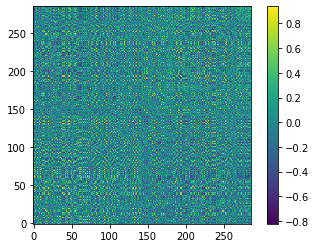

In [27]:
plt.imshow(FHA_FCs[0,:,:,1],origin='lower')
plt.colorbar()
plt.show()

## Deep Learning

In [28]:
import torch
from torch import nn, optim
from torch.utils import data
from sklearn.preprocessing import StandardScaler

# GPU is available? If so, we use it.
use_cuda = torch.cuda.is_available() 
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    cudnn.benchmark = True

In [29]:

# Tangent space regularization
reference_mats = ['euclid']
for ref in reference_mats:
    # Navigate tree and get raw correlation FC matrices
    print("Importing correlation matrices...", end=" ")
    all_FC, nSubj = get_data(3)
    print("All FCs successfully loaded!\n")
    print(f"Using {ref} reference in tangent space!")
    all_FC = tangential(all_FC, ref)
    replicates = np.arange(1, 4)
    all_acc, all_loss = {}, {}
    # Prepare train, validation, and test data for NN
    print("Preparing data for CNN...", end=" ")
    train_loader, val_loader, test_loader = prepare_data(all_FC, pos_indices, nSubj)
    print("done!\n")
    # Max epochs of training, early stopping threshold, learning rate
    max_epochs, n_epochs_stop, lr = 20, 10, 1e-4
    # Loop over iterations of the model
    for rep in replicates:
        model, loss_fn, opt, history = build_model(lr)
        print(f"Now training model {rep} of {replicates[-1]}...")
        model, history = train_model(model, opt, loss_fn, train_loader,
                                     val_loader, max_epochs, n_epochs_stop,
                                     history)
        accuracy = test_model(model, test_loader)
        all_acc[rep] = accuracy
        all_loss[rep] = min(history['val_loss'])
        print(f'Model {rep} - Accuracy: {accuracy}; Loss: {all_loss[rep]}')
    # Write to dataframe and to csv
    filename = f'../results/Alcohol_Tan{ref}_PCANA.csv'
    results = pd.DataFrame.from_dict(
        all_acc, orient='index', columns=['Accuracy'])
    results["Loss"] = pd.Series(all_loss)
    results.to_csv(filename)

Importing correlation matrices... (62, 286, 286)
All FCs successfully loaded!

Using euclid reference in tangent space!


/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in power
/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log


Preparing data for CNN... done!

Now training model 1 of 3...


/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 1 / 20,train loss:  0.1335,train acc:  0.436, val loss:  0.892,val acc:  0.500


RuntimeError: Assertion `x >= 0. && x <= 1.' failed. input value should be between 0~1, but got 1.014903 at /Users/distiller/project/conda/conda-bld/pytorch_1579022061893/work/aten/src/THNN/generic/BCECriterion.c:60